<a href="https://colab.research.google.com/github/AlexKostjuk/dz_15/blob/master/dz_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install 'tensorflow[and-cuda]'

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, regularizers
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import kagglehub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist, imdb
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import pickle
import os
import tarfile
import urllib.request
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split



In [2]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
max_features = 20000
maxlen = 500

In [4]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)

спробуємо порівняти сирий датасет підготований мною та датасет завантажений з keras

In [5]:
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_path = "aclImdb_v1.tar.gz"

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)

In [6]:

if not os.path.exists("aclImdb"):
    with tarfile.open(dataset_path, "r:gz") as tar:
        tar.extractall()

In [8]:

def load_imdb_raw(data_dir="aclImdb"):
  # """збір усіх відгуків в reviews та  створеня labels позитивні 1 негативні 0 """
    reviews = []
    labels = []

    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            folder = os.path.join(data_dir, split, sentiment)
            for filename in os.listdir(folder):
                if filename.endswith(".txt"):
                    with open(os.path.join(folder, filename), "r", encoding="utf-8") as f:
                        reviews.append(f.read())
                    labels.append(1 if sentiment == "pos" else 0)

    return labels, reviews

In [9]:
labels, reviews = load_imdb_raw()


In [12]:
def preprocess_text(text):
  # """видалення стоп слів, пунктуації, токенізація"""
    text = text.lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [13]:
dataset = pd.DataFrame({"labels": labels, "reviews": reviews})
dataset["reviews"] = dataset["reviews"].apply(preprocess_text)

In [14]:
dataset.head()

,labels,reviews
0,1,br br dark sweet strange mix sensuality dullne...
1,1,remember film many year ago certainly best fil...
2,1,college student studying alevels need help com...
3,1,engaging intelligent wellmade film liam neeson...
4,1,steve carell star person relate tosort dan rea...


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   labels   50000 non-null  int64 
 1   reviews  50000 non-null  object
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


скачався та розпакувався добре

In [16]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(dataset["reviews"])
sequences = tokenizer.texts_to_sequences(dataset["reviews"])
X = pad_sequences(sequences, maxlen=maxlen, dtype='int32')
y = np.array(dataset["labels"].values, dtype='int32')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = models.Sequential([
    layers.Embedding(input_dim=max_features, output_dim=128, input_length=maxlen),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True,
                                    kernel_regularizer=regularizers.l2(0.01))),
    layers.LSTM(32, return_sequences=False),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
history = model.fit(X_train, y_train,
                   epochs=7,
                   batch_size=64,
                   validation_split=0.2,
                   callbacks=[early_stopping])


Epoch 1/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.6027 - loss: 3.2417 - val_accuracy: 0.8792 - val_loss: 1.3720
Epoch 2/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9044 - loss: 1.0962 - val_accuracy: 0.8932 - val_loss: 0.6426
Epoch 3/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.9376 - loss: 0.4936 - val_accuracy: 0.8878 - val_loss: 0.4634
Epoch 4/7
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.9573 - loss: 0.2881 - val_accuracy: 0.8926 - val_loss: 0.4095


In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nТочність на тестових даних: {test_acc:.4f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9011 - loss: 0.6274

Точність на тестових даних: 0.8995


датасет від keras

In [24]:
(x_train1, y_train1), (x_test1, y_test1) = imdb.load_data(num_words=max_features)


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
x_train1 = pad_sequences(x_train1, maxlen=maxlen)
x_test1 = pad_sequences(x_test1, maxlen=maxlen)

In [26]:
model1 = models.Sequential([
    layers.Embedding(input_dim=max_features, output_dim=128, input_length=maxlen),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True,
                                    kernel_regularizer=regularizers.l2(0.01))),
    layers.LSTM(32, return_sequences=False),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [27]:
model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
history1 = model1.fit(x_train1, y_train1,
                     epochs=7,
                     batch_size=64,
                     validation_split=0.2,
                     callbacks=[early_stopping])

Epoch 1/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 63ms/step - accuracy: 0.6547 - loss: 1.7316 - val_accuracy: 0.7276 - val_loss: 0.6125
Epoch 2/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8815 - loss: 0.3416 - val_accuracy: 0.8526 - val_loss: 0.3558
Epoch 3/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.9282 - loss: 0.2203 - val_accuracy: 0.8706 - val_loss: 0.3509
Epoch 4/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.9547 - loss: 0.1518 - val_accuracy: 0.8670 - val_loss: 0.3980
Epoch 5/7
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9717 - loss: 0.0996 - val_accuracy: 0.8700 - val_loss: 0.4453


In [29]:
test_loss1, test_acc1 = model1.evaluate(x_test1, y_test1)
print(f'\nТочність на тестових даних: {test_acc1:.4f}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.8603 - loss: 0.3735

Точність на тестових даних: 0.8608


In [30]:
plt.figure(figsize=(20, 12))


<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

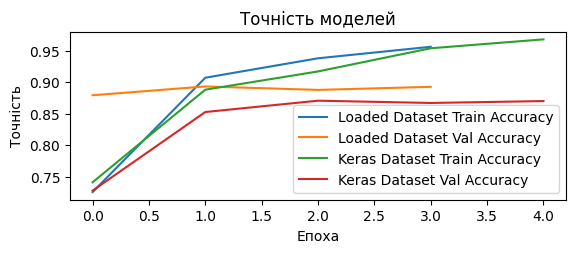

In [31]:
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Loaded Dataset Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Loaded Dataset Val Accuracy')
plt.plot(history1.history['accuracy'], label='Keras Dataset Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Keras Dataset Val Accuracy')
plt.title('Точність моделей')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()

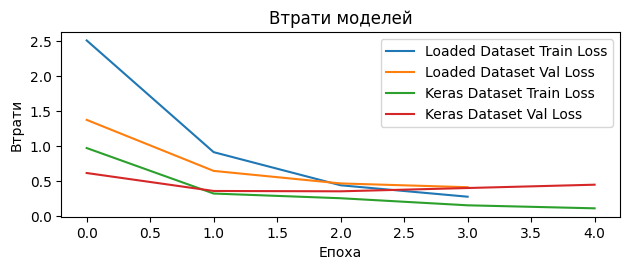

In [32]:
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Loaded Dataset Train Loss')
plt.plot(history.history['val_loss'], label='Loaded Dataset Val Loss')
plt.plot(history1.history['loss'], label='Keras Dataset Train Loss')
plt.plot(history1.history['val_loss'], label='Keras Dataset Val Loss')
plt.title('Втрати моделей')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()

plt.tight_layout()
plt.show()

з отриманих данних можна побачити що підготовка сирого датасету пройшла досить не погано він показав трохи кращі результати за датасет від Keras але з графіків можна помітимти що скоріш за все обидві моделі преренавчені